In [3]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit

time_conv = 977.79222167

In [4]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [5]:
sn0_list = []
sn1_list = []
# sn1G_list = []
# sn1Gnw_list = []
# sn1GnwCOM_list = []
idx_list = np.arange(0, 600, 50)
# idx_list = np.arange(0, 60, 10)
# idx_list = [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
fields=['Coordinates', 'Velocities', 'Masses', 'Acceleration']
for idx in tqdm(idx_list):
    sn0 = read_snap(idx, 0, lvl='lvl3', parttype=None, fields=None)
    sn0_list.append(sn0)
    
    try:
        sn1 = read_snap(idx, 1, lvl='lvl3', parttype=None, fields=None)
        sn1_list.append(sn1)
    except:
        pass


A Jupyter Widget

In [6]:
from numba import njit
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

def compute_angmom_torque(sn, center=np.array([200., 200., 200.])):
    angmom = []
    torque_list = []
    for i in range(6):
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos = part.pos.value - center
            vel = part.vel.value
            acc = part.acce
            
            if sn.MassTable[i] > 0.0:
                mass = sn.MassTable[i]
                mom = mass * vel
                frc = mass * acc
            else:
                mass = part.mass.value
                mom = my_mult(mass, vel)
                frc = my_mult(mass, acc)
            
#             ang = np.cross(pos, mom)
#             print(i)
#             print(np.shape(mom))
            angz = np.sum(pos[:,0]*mom[:,1] - pos[:,1]*mom[:,0])
#             ang = np.sum(ang, axis=0)
#             print(np.shape(ang))
            ang = np.array([0., 0., angz])
    
            torque = np.cross(pos, frc)
            torque = np.sum(torque, axis=0)
            torque_list.append(torque.tolist())
    
            angmom.append(ang.tolist())
            
        else:
            ang = np.array([0., 0., 0.])
            angmom.append(ang.tolist())
            torque_list.append(ang.tolist())
    return np.array(angmom), np.array(torque_list)

def compute_angmom_from_track(sn, axis=2):
    if sn.NumPart_Total[4] > 0.0:
        angmom_SNe = np.sum(sn.part4.Cum_FeedbackAngMomentumInjectedVec[:,axis])
        angmom_AGB = np.sum(sn.part4.Cum_FeedbackAngMomentumAGBVec[:,axis])
        angmom_Rad = np.sum(sn.part4.Cum_RadAngMomentumRealInjectedVec[:,axis])
    else:
        angmom_SNe = 0.0
        angmom_AGB = 0.0
        angmom_Rad = 0.0
    
    return angmom_SNe, angmom_AGB, angmom_Rad

In [7]:
sn = sn0_list[-1]
pos = sn.part2.pos.value
acc = sn.part2.acce

torque = np.cross(pos, acc)
print(np.shape(torque))
np.sum(torque, axis=0)


(6444416, 3)


array([ 60616379.93306526,   9686329.89352861, -89475143.82784756])

In [8]:
angmom0_list = []
torque0_list = []
angmom1_list= []
torque1_list = []
# angmom1_track_list = []
# angmom1G_list = []
# angmom1Gnw_list = []
# angmom1GnwCOM_list = []
for i,idx in enumerate(tqdm(idx_list)):
    ang, trq = compute_angmom_torque(sn0_list[i], center=np.array([0, 0, 0]))
    angmom0_list.append(ang)
    torque0_list.append(trq)
    try:
        ang, trq = compute_angmom_torque(sn1_list[i], center=np.array([200., 200., 200.]))
        angmom1_list.append(ang)
        torque1_list.append(trq)
        
#         angmom1_track_list.append(compute_angmom_from_track(sn1_list[i]))
    except:
        pass

angmom0_list = np.array(angmom0_list)
angmom1_list = np.array(angmom1_list)

torque0_list = np.array(torque0_list)
torque1_list = np.array(torque1_list)

A Jupyter Widget

In [9]:
def print_tot_change(a):
    print(np.sum(a[:,:,2], axis=1) - np.sum(a[:,:,2], axis=1)[0])

print_tot_change(angmom0_list)
print_tot_change(angmom1_list)
# print_tot_change(angmom1G_list)
# print_tot_change(angmom1Gnw_list)
# print_tot_change(angmom1GnwCOM_list)

[ 0.          0.2851231   5.2394157   9.20447903 10.06090674 10.62805575
 11.30492286 11.9707552  12.43245025 12.40090709 12.29260752 12.25705501]
[ 0.         -1.71453852 -1.2066587  -0.10009295  1.89754904  2.49080324
  3.7469735   5.21645245  6.50805664  7.87138358  9.08322866 10.60919878]


In [10]:
time0_list = []
time1_list = []
# time6i_list = []
for i,idx in enumerate(tqdm(idx_list)):
    time0_list.append(sn0_list[i].Time)
    try:
        time1_list.append(sn1_list[i].Time)
    except:
        pass


time0_list = np.array(time0_list)
time1_list = np.array(time1_list)


A Jupyter Widget

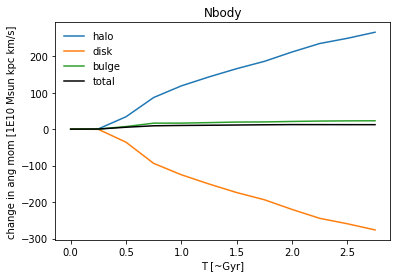

In [11]:
plt.plot(time0_list, angmom0_list[:,1,2] - angmom0_list[:,1,2][0], label='halo')
plt.plot(time0_list, angmom0_list[:,2,2] - angmom0_list[:,2,2][0], label='disk')
plt.plot(time0_list, angmom0_list[:,3,2] - angmom0_list[:,3,2][0], label='bulge')
plt.plot(time0_list, np.sum(angmom0_list[:,:,2], axis=1) - np.sum(angmom0_list[:,:,2], axis=1)[0], label='total', c='k')
plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('change in ang mom [1E10 Msun kpc km/s]')
plt.title('Nbody')
plt.show()

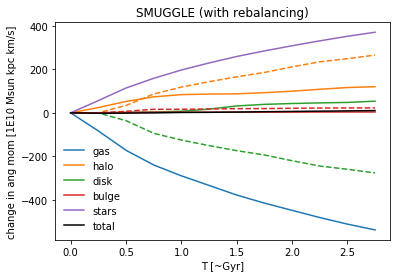

In [12]:
l = plt.plot(time1_list, angmom1_list[:,0,2] - angmom1_list[:,0,2][0], label='gas')

l = plt.plot(time1_list, angmom1_list[:,1,2] - angmom1_list[:,1,2][0], label='halo')
plt.plot(time0_list, angmom0_list[:,1,2] - angmom0_list[:,1,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time1_list, angmom1_list[:,2,2] - angmom1_list[:,2,2][0], label='disk')
plt.plot(time0_list, angmom0_list[:,2,2] - angmom0_list[:,2,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time1_list, angmom1_list[:,3,2] - angmom1_list[:,3,2][0], label='bulge')
plt.plot(time1_list, angmom0_list[:,3,2] - angmom0_list[:,3,2][0], c=l[0].get_color(), ls='dashed')

plt.plot(time1_list, angmom1_list[:,4,2] - angmom1_list[:,4,2][0], label='stars')
plt.plot(time1_list, np.sum(angmom1_list[:,:,2], axis=1) - np.sum(angmom1_list[:,:,2], axis=1)[0], label='total', c='k')

# plt.plot(time1_list, angmom1_track_list[:,0], ls='dashed', label='SNe')
# plt.plot(time1_list, angmom1_track_list[:,1], ls='dashed', label='AGB')
# plt.plot(time1_list, angmom1_track_list[:,2], ls='dashed', label='Rad')
# plt.plot(time1_list, np.sum(angmom1_track_list, axis=1), ls='dashed', label='total', c='k')



plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('change in ang mom [1E10 Msun kpc km/s]')
plt.title('SMUGGLE (with rebalancing)')
plt.show()

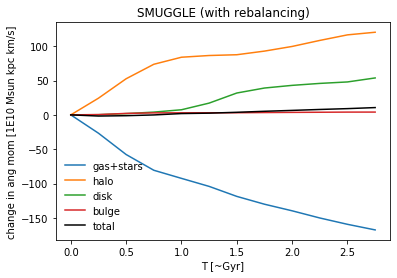

In [13]:
l = plt.plot(time1_list, angmom1_list[:,0,2] - angmom1_list[:,0,2][0]
                        +angmom1_list[:,4,2] - angmom1_list[:,4,2][0], label='gas+stars')

l = plt.plot(time1_list, angmom1_list[:,1,2] - angmom1_list[:,1,2][0], label='halo')
# plt.plot(time0_list, angmom0_list[:,1,2] - angmom0_list[:,1,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time1_list, angmom1_list[:,2,2] - angmom1_list[:,2,2][0], label='disk')
# plt.plot(time0_list, angmom0_list[:,2,2] - angmom0_list[:,2,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time1_list, angmom1_list[:,3,2] - angmom1_list[:,3,2][0], label='bulge')
# plt.plot(time1_list, angmom0_list[:,3,2] - angmom0_list[:,3,2][0], c=l[0].get_color(), ls='dashed')



plt.plot(time1_list, np.sum(angmom1_list[:,:,2], axis=1) - np.sum(angmom1_list[:,:,2], axis=1)[0], label='total', c='k')

# plt.plot(time1_list, angmom1_track_list[:,0], ls='dashed', label='SNe')
# plt.plot(time1_list, angmom1_track_list[:,1], ls='dashed', label='AGB')
# plt.plot(time1_list, angmom1_track_list[:,2], ls='dashed', label='Rad')
# plt.plot(time1_list, np.sum(angmom1_track_list, axis=1), ls='dashed', label='total', c='k')



plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('change in ang mom [1E10 Msun kpc km/s]')
plt.title('SMUGGLE (with rebalancing)')
plt.show()

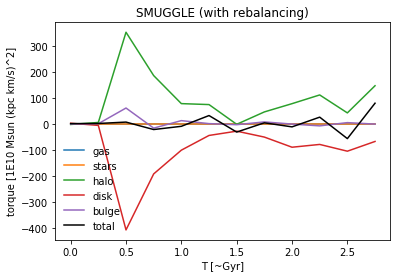

In [14]:
l = plt.plot(time0_list, torque0_list[:,0,2], label='gas')
l = plt.plot(time0_list, torque0_list[:,4,2], label='stars')

l = plt.plot(time0_list, torque0_list[:,1,2], label='halo')
# plt.plot(time0_list, angmom0_list[:,1,2] - angmom0_list[:,1,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time0_list, torque0_list[:,2,2], label='disk')
# plt.plot(time0_list, angmom0_list[:,2,2] - angmom0_list[:,2,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time0_list, torque0_list[:,3,2], label='bulge')
# plt.plot(time1_list, angmom0_list[:,3,2] - angmom0_list[:,3,2][0], c=l[0].get_color(), ls='dashed')



plt.plot(time1_list, np.sum(torque0_list[:,:,2], axis=1), label='total', c='k')

# plt.plot(time1_list, angmom1_track_list[:,0], ls='dashed', label='SNe')
# plt.plot(time1_list, angmom1_track_list[:,1], ls='dashed', label='AGB')
# plt.plot(time1_list, angmom1_track_list[:,2], ls='dashed', label='Rad')
# plt.plot(time1_list, np.sum(angmom1_track_list, axis=1), ls='dashed', label='total', c='k')



plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('torque [1E10 Msun (kpc km/s)^2]')
plt.title('SMUGGLE (with rebalancing)')
plt.show()

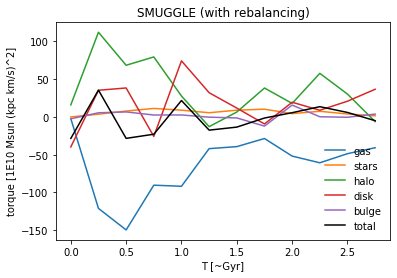

In [15]:
l = plt.plot(time1_list, torque1_list[:,0,2], label='gas')
l = plt.plot(time1_list, torque1_list[:,4,2], label='stars')

l = plt.plot(time1_list, torque1_list[:,1,2], label='halo')
# plt.plot(time0_list, angmom0_list[:,1,2] - angmom0_list[:,1,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time1_list, torque1_list[:,2,2], label='disk')
# plt.plot(time0_list, angmom0_list[:,2,2] - angmom0_list[:,2,2][0], c=l[0].get_color(), ls='dashed')

l = plt.plot(time1_list, torque1_list[:,3,2], label='bulge')
# plt.plot(time1_list, angmom0_list[:,3,2] - angmom0_list[:,3,2][0], c=l[0].get_color(), ls='dashed')



plt.plot(time1_list, np.sum(torque1_list[:,:,2], axis=1), label='total', c='k')

# plt.plot(time1_list, angmom1_track_list[:,0], ls='dashed', label='SNe')
# plt.plot(time1_list, angmom1_track_list[:,1], ls='dashed', label='AGB')
# plt.plot(time1_list, angmom1_track_list[:,2], ls='dashed', label='Rad')
# plt.plot(time1_list, np.sum(angmom1_track_list, axis=1), ls='dashed', label='total', c='k')



plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('torque [1E10 Msun (kpc km/s)^2]')
plt.title('SMUGGLE (with rebalancing)')
plt.show()

In [16]:
# SMUGGLE
plt.plot(time1_list, np.sum(angmom1_list[:,:,2], axis=1) - np.sum(angmom1_list[:,:,2], axis=1)[0], label='SMUGGLE', c='b')

plt.plot(time1_list, np.sum(angmom1_track_list, axis=1), ls='dashed', label='SMUGGLE (from stars)', c='b')


# GFM
plt.plot(time1G_list, np.sum(angmom1G_list[:,:,2], axis=1) - np.sum(angmom1G_list[:,:,2], axis=1)[0], label='GFM', c='r')
plt.plot(time1Gnw_list, np.sum(angmom1Gnw_list[:,:,2], axis=1) - np.sum(angmom1Gnw_list[:,:,2], axis=1)[0], label='GFM (no winds)', c='g')
plt.plot(time1GnwCOM_list, np.sum(angmom1GnwCOM_list[:,:,2], axis=1) - np.sum(angmom1GnwCOM_list[:,:,2], axis=1)[0], label='GFM (no winds, COM)', c='g', ls='dashed')

plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('change in ang mom [1E10 Msun kpc km/s]')
plt.axhline(0, c='k')
plt.title('SMUGGLE vs GFM')
plt.show()

NameError: name 'angmom1_track_list' is not defined

In [ ]:
np.sum(angmom1_track_list, axis=1)/(np.sum(angmom1_list[:,:,2], axis=1) - np.sum(angmom1_list[:,:,2], axis=1)[0])

## Angular momentum by component 2
Splitting the disk into two components, `R<4kpc` and `R>4kpc`

In [ ]:
from numba import njit
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

def compute_angmom_split(sn, center=np.array([200., 200., 200.]), Rcut=4):
    angmom = np.zeros((6, 3))
    for i in range(5):
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos = part.pos.value - center
            vel = part.vel.value
            
            if i==2:
                Rmag = np.linalg.norm(pos, axis=1)
                key_less = Rmag < Rcut
                key_more = Rmag > Rcut
            
            if sn.MassTable[i] > 0.0:
                mass = sn.MassTable[i]
                mom = mass * vel
            else:
                mass = part.mass.value
                mom = my_mult(mass, vel)
            
#             ang = np.cross(pos, mom)
#             print(i)
#             print(np.shape(mom))
            if i==2:
                angz = pos[:,0]*mom[:,1] - pos[:,1]*mom[:,0]
                angz_in = np.sum(angz[key_less])
                angz_out = np.sum(angz[key_more])
                
                ang_in = np.array([0., 0., angz_in])
                ang_out = np.array([0., 0., angz_out])
                
                angmom[2,:] = ang_in
                angmom[5,:] = ang_out
            else:
                angz = np.sum(pos[:,0]*mom[:,1] - pos[:,1]*mom[:,0])
                ang = np.array([0., 0., angz])
            
                angmom[i,:] = ang
        else:
            ang = np.array([0., 0., 0.])
            angmom[i,:] = ang
    return np.array(angmom)

def compute_angmom_from_track(sn, axis=2):
    if sn.NumPart_Total[4] > 0.0:
        angmom_SNe = np.sum(sn.part4.Cum_FeedbackAngMomentumInjectedVec[:,axis])
        angmom_AGB = np.sum(sn.part4.Cum_FeedbackAngMomentumAGBVec[:,axis])
        angmom_Rad = np.sum(sn.part4.Cum_RadAngMomentumRealInjectedVec[:,axis])
    else:
        angmom_SNe = 0.0
        angmom_AGB = 0.0
        angmom_Rad = 0.0
    
    return angmom_SNe, angmom_AGB, angmom_Rad

In [ ]:
angmom0_split_list = []
angmom1_split_list= []
# angmom1_split_track_list = []
# angmom1G_split_list = []
for i,idx in enumerate(tqdm(idx_list)):
    angmom0_split_list.append(compute_angmom_split(sn0_list[i], center=np.array([0, 0, 0])))
    try:
        angmom1_split_list.append(compute_angmom_split(sn1_list[i], center=np.array([200., 200., 200.])))
#         angmom1_track_list.append(compute_angmom_from_track(sn1_list[i]))
    except:
        pass
    
#     try:
#         angmom1G_split_list.append(compute_angmom(sn1G_list[i], center=np.array([200., 200., 200.])))
#     except:
#         pass

angmom0_split_list = np.array(angmom0_split_list)
angmom1_split_list = np.array(angmom1_split_list)
# angmom1_track_list = np.array(angmom1_track_list)
# angmom1G_split_list = np.array(angmom1G_split_list)

In [ ]:
time0_list_l3 = []
time1_list_l3 = []
# time1G_list_l3 = []
# time6i_list = []
for i,idx in enumerate(tqdm(idx_list)):
    time0_list_l3.append(sn0_list_l3[i].Time)
    try:
        time1_list_l3.append(sn1_list_l3[i].Time)
#         time1G_list_l3.append(sn1G_list_l3[i].Time)
    except:
        pass
time0_list_l3 = np.array(time0_list_l3)
time1_list_l3 = np.array(time1_list_l3)
# time1G_list_l3 = np.array(time1G_list_l3)
# time6i_list = np.array(time6i_list)

In [ ]:
plt.plot(time0_list, angmom0_split_list[:,1,2] - angmom0_split_list[:,1,2][0], label='halo')
plt.plot(time0_list, angmom0_split_list[:,2,2] - angmom0_split_list[:,2,2][0], label='disk (R<4kpc)')
plt.plot(time0_list, angmom0_split_list[:,5,2] - angmom0_split_list[:,5,2][0], label='disk (R>4kpc)')
plt.plot(time0_list, angmom0_split_list[:,3,2] - angmom0_split_list[:,3,2][0], label='bulge')
plt.plot(time0_list, np.sum(angmom0_split_list[:,:,2], axis=1) - np.sum(angmom0_split_list[:,:,2], axis=1)[0], label='total', c='k')
plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('change in ang mom [1E10 Msun kpc km/s]')
plt.title('Nbody')
plt.show()

In [ ]:

plt.plot(time1_list, angmom1_split_list[:,1,2] - angmom1_split_list[:,1,2][0], label='halo')
plt.plot(time1_list, angmom1_split_list[:,2,2] - angmom1_split_list[:,2,2][0], label='disk (R<4kpc)')
plt.plot(time1_list, angmom1_split_list[:,5,2] - angmom1_split_list[:,5,2][0], label='disk (R>4kpc)')
plt.plot(time1_list, angmom1_split_list[:,3,2] - angmom1_split_list[:,3,2][0], label='bulge')
plt.plot(time1_list, angmom1_split_list[:,0,2] - angmom1_split_list[:,0,2][0], label='gas')
plt.plot(time1_list, angmom1_split_list[:,4,2] - angmom1_split_list[:,4,2][0], label='stars')
plt.plot(time1_list, np.sum(angmom1_split_list[:,:,2], axis=1) - np.sum(angmom1_split_list[:,:,2], axis=1)[0], label='total', c='k')

plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('change in ang mom [1E10 Msun kpc km/s]')
plt.title('SMUGGLE (with rebalancing)')
plt.show()

## Total Torque of each component

In [ ]:
from numba import njit
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

def compute_angmom(sn, center=np.array([200., 200., 200.])):
    angmom = []
    for i in range(6):
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos = part.pos.value - center
            vel = part.vel.value
            acc = part.acc.valuie
            
            if sn.MassTable[i] > 0.0:
                mass = sn.MassTable[i]
                mom = mass * vel
            else:
                mass = part.mass.value
                mom = my_mult(mass, vel)
            
#             ang = np.cross(pos, mom)
#             print(i)
#             print(np.shape(mom))
            angz = np.sum(pos[:,0]*mom[:,1] - pos[:,1]*mom[:,0])
#             ang = np.sum(ang, axis=0)
#             print(np.shape(ang))
            ang = np.array([0., 0., angz])
            angmom.append(ang.tolist())
        else:
            ang = np.array([0., 0., 0.])
            angmom.append(ang.tolist())
    return np.array(angmom)